In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# [1] First step: Setting up the basics

### Import all of the libraries that we will need

In [2]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier
from pyspark.ml.feature import *
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.sql.functions import *

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, ImageColorGenerator

### Get the data

In [3]:
! wget http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/reviews_Video_Games_5.json.gz

--2019-08-25 14:39:17--  http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/reviews_Video_Games_5.json.gz
Resolving snap.stanford.edu (snap.stanford.edu)... 171.64.75.80
Connecting to snap.stanford.edu (snap.stanford.edu)|171.64.75.80|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 113104579 (108M) [application/x-gzip]
Saving to: ‘reviews_Video_Games_5.json.gz’

reviews_Video_Games 100%[===================>] 107.86M  1.10MB/s    in 3m 6s   

2019-08-25 14:42:23 (593 KB/s) - ‘reviews_Video_Games_5.json.gz’ saved [113104579/113104579]



In [4]:
! gunzip reviews_Video_Games_5.json.gz

# [2] DATA PREPARATION, EXTRACTION, TRANSFORMATION, LOADING

## PREPARATION

### Confirm the data file structure, prior to diving into our analysis
- Start by viewing a small sample
- Examine the data to determine the data types, delimiter (if applicable), and any possible problems with the data

In [5]:
! head -1 reviews_Video_Games_5.json

{"reviewerID": "A2HD75EMZR8QLN", "asin": "0700099867", "reviewerName": "123", "helpful": [8, 12], "reviewText": "Installing the game was a struggle (because of games for windows live bugs).Some championship races and cars can only be \"unlocked\" by buying them as an addon to the game. I paid nearly 30 dollars when the game was new. I don't like the idea that I have to keep paying to keep playing.I noticed no improvement in the physics or graphics compared to Dirt 2.I tossed it in the garbage and vowed never to buy another codemasters game. I'm really tired of arcade style rally/racing games anyway.I'll continue to get my fix from Richard Burns Rally, and you should to. :)http://www.amazon.com/Richard-Burns-Rally-PC/dp/B000C97156/ref=sr_1_1?ie=UTF8&qid;=1341886844&sr;=8-1&keywords;=richard+burns+rallyThank you for reading my review! If you enjoyed it, be sure to rate it as helpful.", "overall": 1.0, "summary": "Pay to unlock content? I don't think so.", "unixReviewTime": 1341792000, "r

### Do a simple line count to see how much data we have to manage/manipulate

In [6]:
! wc -l reviews_Video_Games_5.json

231780 reviews_Video_Games_5.json


## EXTRACTION

## Read in the data file (json file)
Since the nice people at UCSD did a very good job of cleaning it up, we can trust it.

In [7]:
video_games = spark.read.format("json").option("inferSchema", "true").load("reviews_Video_Games_5.json")

### Cache the initial dataframe to cut down on processing time; we'll be seeing this very often

In [8]:
video_games.cache()

DataFrame[asin: string, helpful: array<bigint>, overall: double, reviewText: string, reviewTime: string, reviewerID: string, reviewerName: string, summary: string, unixReviewTime: bigint]

### Look at the DF schema to:
- examine the structure
- make sure all of the data types imported properly

In [9]:
video_games.printSchema()

root
 |-- asin: string (nullable = true)
 |-- helpful: array (nullable = true)
 |    |-- element: long (containsNull = true)
 |-- overall: double (nullable = true)
 |-- reviewText: string (nullable = true)
 |-- reviewTime: string (nullable = true)
 |-- reviewerID: string (nullable = true)
 |-- reviewerName: string (nullable = true)
 |-- summary: string (nullable = true)
 |-- unixReviewTime: long (nullable = true)



Below provides an overview of the data and what kind of data each column contains

- reviewerID - ID of the reviewer, e.g. A2SUAM1J3GNN3B
- asin - ID of the product, e.g. 0000013714
- reviewerName - name of the reviewer
- helpful - helpfulness rating of the review, e.g. 2/3
- reviewText - text of the review
- overall - rating of the product
- summary - summary of the review
- unixReviewTime - time of the review (unix time)
- reviewTime - time of the review (raw)

## TRANSFORMATION / LOADING

### Do a little pre-work first - adding / dropping columns

* Merge the `summary` text with the `review` text to have it all in one column, as there are different information in both places
* Remove some unneccessary columns that won't be used for the regression

In [10]:
rating_df1 = video_games.withColumn("review_summary", concat(col("summary"), lit(" "), col("reviewText"))).drop("summary").drop("reviewText").drop("reviewerName")

rating_df1.cache()

DataFrame[asin: string, helpful: array<bigint>, overall: double, reviewTime: string, reviewerID: string, unixReviewTime: bigint, review_summary: string]

Let's take a peak to see ensure it's how we want it

In [11]:
rating_df1.limit(5).toPandas()

,asin,helpful,overall,reviewTime,reviewerID,unixReviewTime,review_summary
0,0700099867,"[8, 12]",1.0,"07 9, 2012",A2HD75EMZR8QLN,1341792000,Pay to unlock content? I don't think so. Insta...
1,0700099867,"[0, 0]",4.0,"06 30, 2013",A3UR8NLLY1ZHCX,1372550400,Good rally game If you like rally cars get thi...
2,0700099867,"[0, 0]",1.0,"06 28, 2014",A1INA0F5CWW3J4,1403913600,Wrong key 1st shipment received a book instead...
3,0700099867,"[7, 10]",3.0,"09 14, 2011",A1DLMTOTHQ4AST,1315958400,"awesome game, if it did not crash frequently !..."
4,0700099867,"[2, 2]",4.0,"06 14, 2011",A361M14PU2GUEG,1308009600,DIRT 3 I had Dirt 2 on Xbox 360 and it was an ...


### Get summary statistics, see if there are any missing values, etc.

In [12]:
rating_df1.describe().show()

+-------+-------------------+------------------+----------+--------------------+--------------------+--------------------+
|summary|               asin|           overall|reviewTime|          reviewerID|      unixReviewTime|      review_summary|
+-------+-------------------+------------------+----------+--------------------+--------------------+--------------------+
|  count|             231780|            231780|    231780|              231780|              231780|              231780|
|   mean|7.198617864286957E9| 4.086396582966606|      null|                null|1.2772167980533264E9|                null|
| stddev|3.628023820739709E9|1.2023296087789064|      null|                null|1.1557837617591812E8|                null|
|    min|         0700099867|               1.0|01 1, 2000|A00263941WP7WCIL7...|           939859200|  ! 2 words bey this|
|    max|         B00KHECZXO|               5.0|12 9, 2013|       AZZTC2OYVNE2Q|          1405987200|~This was well ma...|
+-------+-------

## We will begin sentiment analysis; trying to determine if there are certain words that indicate a good (4-5 stars) / bad (1-2 stars) rating
### Continue to transform the data for our specific analysis

* Filter out any review scores that are neutral, i.e. 3; these will not help our first regression model/analysis
* Create a `label` column based on review score
<br>
-- Any review score <= 2.0 are **negative** reviews and get a 0.0 label
<br>
** Any review score >= 4.0 are _positive_ reviews and get a 1.0 label
* Demonstrate the transformation was successful by displaying the counts for each label

In [13]:
rating_df2 = rating_df1.filter("overall !=3")

bucketizer = Bucketizer().setInputCol("overall").setOutputCol("label").setSplits((0.0, 4.0, 5.0))

rating_df3 = bucketizer.transform(rating_df2)

rating_df3.groupBy("overall","label").count().show()

+-------+-----+------+
|overall|label| count|
+-------+-----+------+
|    2.0|  0.0| 13663|
|    5.0|  1.0|120185|
|    1.0|  0.0| 14853|
|    4.0|  1.0| 54804|
+-------+-----+------+



### The old trusty train and test data set split; we use 70/30 for our split

* By splitting the data, we are able to train a model (based on training data) and evaluate it on our testing data
* Again, just print out our counts to see what we are working with

In [14]:
rating_df3.cache()

DataFrame[asin: string, helpful: array<bigint>, overall: double, reviewTime: string, reviewerID: string, unixReviewTime: bigint, review_summary: string, label: double]

In [15]:
train_rating, test_rating = rating_df3.randomSplit([0.7, 0.3])
train_rating.cache()
test_rating.cache()

DataFrame[asin: string, helpful: array<bigint>, overall: double, reviewTime: string, reviewerID: string, unixReviewTime: bigint, review_summary: string, label: double]

Let's check what the counts are for each dataset

In [16]:
print(train_rating.count())
print(test_rating.count())

142853
60652


# [3] LOGISTIC REGRESSION MODELING - STAR RATINGS

### A few more steps required before we can complete the model, we need to continue to clean and prep the data

* `tokenizer` takes all of the words in the review+summary column and converts them into an array of words for the next step in the process
* `remover` removes "stop" words - useless words that provide no additional context or meaning - to simplify and make our analysis cleaner

In [17]:
tokenizer = RegexTokenizer().setInputCol("review_summary").setOutputCol("reviewTokensUf").setPattern("\\s+|[,.()\"]")

remover = StopWordsRemover().setStopWords(StopWordsRemover.loadDefaultStopWords("english")).setInputCol("reviewTokensUf").setOutputCol("reviewTokens")

* `cv` converts the array of word tokens from the previous step to vectors of word token counts. The CountVectorizer finds the number of times a word occurs in a specific blurb of text.

In [18]:
cv = CountVectorizer().setInputCol("reviewTokens").setOutputCol("cv")

* `idf` takes the feature vectors created from the CountVectorizer and down-weights any of those "features" which appear frequently in a collection of texts.  This allows us to measure the _significance_ of the word in the text.  The output features column is what our logistic regression will use. (the IDF part of TF-IDF feature extraction).

In [19]:
idf = IDF().setInputCol("cv").setOutputCol("features")

* `lr` is logistic regression classifier and our estimator, which will train on the vector of labels and features and return a (transformer) model.

In [20]:
lr = LogisticRegression().setMaxIter(100).setRegParam(0.02).setElasticNetParam(0.3)

### Now we compile a pipline.
* A pipeline chains multiple transformers and estimators together to specify an ML workflow for training and using a model. 
* We need to make sure to feed the data to the processes in order: `Tokenizer`, `Remover`, `CountVectorizer`, `IDF`, and `LogisticRegressionClassifier`

In [21]:
pl = Pipeline(stages = [tokenizer, remover, cv, idf, lr])

### We then train the logistic regression model by making associations between the input features and the labeled output associated with those features. The `pipeline.fit` method returns a fitted pipeline model.

In [22]:
model_rating = pl.fit(train_rating)

### We then get the `CountVectorizer` and `LogisticRegression` model from our fitted model, in order to print out the coefficient weights of the words in the text vocabulary (the word feature importance).

*  We grab the review/summary vocabulary using our `CountVectorizer`
*  We grab the coefficients for each one of these words from the `lrModel`
*  This will allow us to understand the importance of certain words and their impact on the model

In [23]:
vocabulary_rating = model_rating.stages[2].vocabulary

Out of curiosity, let's see how many unique words when used in the dataset.

In [24]:
len(vocabulary_rating)

262144

In [25]:
lrModel_rating = model_rating.stages[-1]

In [26]:
weights_rating = lrModel_rating.coefficients.toArray()

* We join our vocabulary with their respective coefficients and put them into a new DataFrame `word_score`

In [27]:
word_score_rating = pd.DataFrame(list(weights_rating), vocabulary_rating).reset_index()
word_score_rating.columns = ["word", "coefficients"]

* Then we can sort the values based on the coefficients, and get the top twenty words from the positive reviews

Let's check out the top 20 words the positively impact the model (indicating a good star rating)

In [28]:
top_20_postive_rating = word_score_rating.sort_values("coefficients", ascending = False).head(20)
top_20_postive_rating

,word,coefficients
6,great,0.412466
19,best,0.261541
34,love,0.187046
110,awesome,0.168150
8,fun,0.146596
195,perfect,0.125619
269,highly,0.122968
196,excellent,0.117110
127,amazing,0.114463
7,good,0.102987


We can do the same for the bottom 20 words from our negative reviews

In [29]:
bottom_20_negative_rating = word_score_rating.sort_values("coefficients").head(20)
bottom_20_negative_rating

,word,coefficients
859,waste,-0.288640
662,worst,-0.277402
342,boring,-0.275632
777,horrible,-0.230252
672,terrible,-0.217876
1511,disappointment,-0.200680
1872,garbage,-0.190550
1160,disappointing,-0.176604
796,poor,-0.174857
1132,sucks,-0.169351


# [4] Visualize

## Generate a word cloud from the two DataFrames - this is dynamic and can be changed to incorporate more words if needed

* Join all the words in the dataframes together
* Use the `WordCloud` library to generate our graphics

In [30]:
pos_text_rating = " ".join(w for w in top_20_postive_rating.word)

In [31]:
pos_wordcloud_rating = WordCloud(background_color = "white").generate(pos_text_rating)

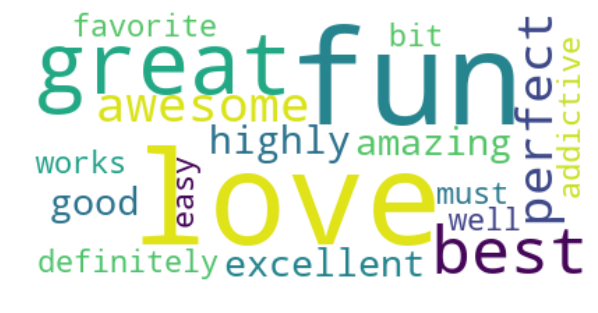

In [32]:
plt.figure(figsize=[10,10])
plt.imshow(pos_wordcloud_rating, interpolation='bilinear')
plt.axis("off")
plt.show()

Let's repeat this for the bottom 20 words

In [33]:
neg_text_rating = " ".join(w for w in bottom_20_negative_rating.word)

In [34]:
neg_wordcloud_rating = WordCloud(background_color = "white").generate(neg_text_rating)

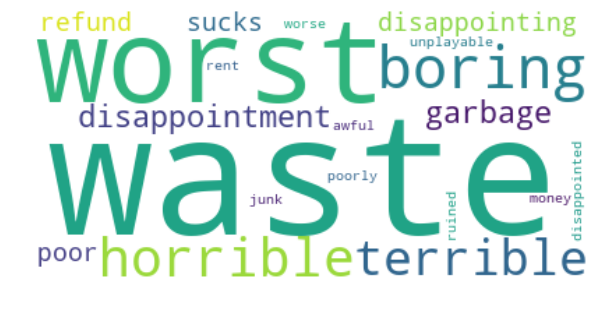

In [35]:
plt.figure(figsize=[10,10])
plt.imshow(neg_wordcloud_rating, interpolation='bilinear')
plt.axis("off")
plt.show()

# [5] Use our model to Predict

### Transform our test data set based on our shiny Logistic Regression model

In [36]:
rating_predictions_df = model_rating.transform(test_rating)

In [37]:
rating_predictions_df.cache()

DataFrame[asin: string, helpful: array<bigint>, overall: double, reviewTime: string, reviewerID: string, unixReviewTime: bigint, review_summary: string, label: double, reviewTokensUf: array<string>, reviewTokens: array<string>, cv: vector, features: vector, rawPrediction: vector, probability: vector, prediction: double]

### Show the output of our ratings_prediction dataframe, to see how well our model did

In [38]:
rating_predictions_df.select("label", "prediction", "rawPrediction").limit(20).show(truncate = False)

+-----+----------+----------------------------------------+
|label|prediction|rawPrediction                           |
+-----+----------+----------------------------------------+
|0.0  |1.0       |[-1.460877717496734,1.460877717496734]  |
|1.0  |1.0       |[-2.3025067475978407,2.3025067475978407]|
|1.0  |0.0       |[0.7794254038345685,-0.7794254038345685]|
|1.0  |1.0       |[-3.646755786102271,3.646755786102271]  |
|0.0  |1.0       |[-0.9227271286766943,0.9227271286766943]|
|0.0  |1.0       |[-1.3411903122354083,1.3411903122354083]|
|0.0  |1.0       |[-1.254156863087029,1.254156863087029]  |
|1.0  |1.0       |[-1.9559007468268876,1.9559007468268876]|
|1.0  |1.0       |[-5.142917682653297,5.142917682653297]  |
|0.0  |1.0       |[-0.3332107818039449,0.3332107818039449]|
|1.0  |1.0       |[-2.126542541650628,2.126542541650628]  |
|0.0  |1.0       |[-0.6226527899716896,0.6226527899716896]|
|1.0  |1.0       |[-2.5726367177696012,2.5726367177696012]|
|1.0  |1.0       |[-2.232043865418089,2.

# [6] Evaluate the Model

### Create a function to formally measure our Logistic Regression

* We use the `BinaryClassificationEvaluator` to get our areaUnderROC
* We use `MulticlassClassificationEvaluator` to get f1, accurary, weighted precision, and weighted recall
* We create a function, as we will likely use these over and over; a function creates efficiencies

In [39]:
def reporting_metrics(prediction_df, label, prediction, rawPrediction):
    
    AoC_eval = BinaryClassificationEvaluator(labelCol = label, rawPredictionCol = rawPrediction, metricName = "areaUnderROC")
    AoC = AoC_eval.evaluate(prediction_df)
    print("AreaUnderROC = %s" % AoC)
    
    f1_eval = MulticlassClassificationEvaluator(labelCol = label, predictionCol = prediction, metricName = "f1")
    f1 = f1_eval.evaluate(prediction_df)
    print("f1 = %s" % f1)
    
    acc_eval = MulticlassClassificationEvaluator(labelCol = label, predictionCol = prediction, metricName = "accuracy")
    acc = acc_eval.evaluate(prediction_df)
    print("Accuracy = %s" % acc)
    
    wp_eval = MulticlassClassificationEvaluator(labelCol= label, predictionCol = prediction, metricName = "weightedPrecision")
    wp = wp_eval.evaluate(prediction_df)
    print("weightedPrecision = %s" % wp)
    
    wr_eval = MulticlassClassificationEvaluator(labelCol= label, predictionCol = prediction, metricName = "weightedRecall")
    wr = wr_eval.evaluate(prediction_df)
    print("weightedRecall = %s" % wr)

### Run our function and see how well our model did!

In [40]:
reporting_metrics(rating_predictions_df, "label", "prediction", "rawPrediction")

AreaUnderROC = 0.9249904422274886
f1 = 0.8762662740817678
Accuracy = 0.8981896722284508
weightedPrecision = 0.8977075103582286
weightedRecall = 0.8981896722284508


# [7] Conduct a Logistic Regression, focusing on helpfulness on reviews

## PREPARATION

### Now we create a new DataFrame `helpfulness_df` for our next set of analyses - looking at how helpful reviewers are when they leave their comments
* We need to take the helpful column and break it apart into useful parts: `helpful_votes` and `total_votes`
* Then we can use these pieces to create `perc_helpful` which shows how mnay people thought a particular review was helpful

In [41]:
helpfulness_df = video_games.withColumn("helpful_votes", video_games.helpful[0]) \
            .withColumn("total_votes", video_games.helpful[1]) \
            .withColumn("perc_helpful", video_games.helpful[0] / video_games.helpful[1] * 100)

In [42]:
helpfulness_df.cache()

DataFrame[asin: string, helpful: array<bigint>, overall: double, reviewText: string, reviewTime: string, reviewerID: string, reviewerName: string, summary: string, unixReviewTime: bigint, helpful_votes: bigint, total_votes: bigint, perc_helpful: double]

* recreate the `review_summary` column so we can do sentiment analysis again

In [43]:
helpfulness_review_df1 = helpfulness_df \
    .withColumn("review_summary", concat(col("summary"), lit(" "), col("reviewText"))) \
    .drop("summary").drop("reviewText").drop("reviewerName")

* Verify the schema and a sample of the data to make sure all of the transformations went as planned

In [44]:
helpfulness_review_df1.printSchema()

root
 |-- asin: string (nullable = true)
 |-- helpful: array (nullable = true)
 |    |-- element: long (containsNull = true)
 |-- overall: double (nullable = true)
 |-- reviewTime: string (nullable = true)
 |-- reviewerID: string (nullable = true)
 |-- unixReviewTime: long (nullable = true)
 |-- helpful_votes: long (nullable = true)
 |-- total_votes: long (nullable = true)
 |-- perc_helpful: double (nullable = true)
 |-- review_summary: string (nullable = true)



In [45]:
helpfulness_review_df1.limit(10).toPandas()

,asin,helpful,overall,reviewTime,reviewerID,unixReviewTime,helpful_votes,total_votes,perc_helpful,review_summary
0,0700099867,"[8, 12]",1.0,"07 9, 2012",A2HD75EMZR8QLN,1341792000,8,12,66.666667,Pay to unlock content? I don't think so. Insta...
1,0700099867,"[0, 0]",4.0,"06 30, 2013",A3UR8NLLY1ZHCX,1372550400,0,0,NaN,Good rally game If you like rally cars get thi...
2,0700099867,"[0, 0]",1.0,"06 28, 2014",A1INA0F5CWW3J4,1403913600,0,0,NaN,Wrong key 1st shipment received a book instead...
3,0700099867,"[7, 10]",3.0,"09 14, 2011",A1DLMTOTHQ4AST,1315958400,7,10,70.000000,"awesome game, if it did not crash frequently !..."
4,0700099867,"[2, 2]",4.0,"06 14, 2011",A361M14PU2GUEG,1308009600,2,2,100.000000,DIRT 3 I had Dirt 2 on Xbox 360 and it was an ...
5,0700099867,"[0, 0]",4.0,"05 11, 2013",A2UTRVO4FDCBH6,1368230400,0,0,NaN,"Good racing game, terrible Windows Live Requir..."
6,0700099867,"[11, 13]",5.0,"08 14, 2011",AN3YYDZAS3O1Y,1313280000,11,13,84.615385,A step up from Dirt 2 and that is terrific! Lo...
7,0700099867,"[1, 4]",1.0,"11 24, 2012",AQTC623NCESZW,1353715200,1,4,25.000000,Crash 3 is correct name AKA Microsoft I can't ...
8,0700099867,"[0, 1]",4.0,"11 14, 2012",A1QJJU33VNC4S7,1352851200,0,1,0.000000,A great game ruined by Microsoft's account man...
9,0700099867,"[1, 1]",2.0,"02 8, 2014",A2JLT2WY0F2HVI,1391817600,1,1,100.000000,Couldn't get this one to work I still haven't ...


## TRANSFORM
* We need to perform similar transformations as before to prepare the data for several different forms of analysis

In [46]:
helpfulness_review_df2 = helpfulness_review_df1.filter("perc_helpful < 40 OR perc_helpful > 60")

bucketizer = Bucketizer().setInputCol("perc_helpful").setOutputCol("label").setSplits((0.0, 40, 100))

helpfulness_review_df3 = bucketizer.transform(helpfulness_review_df2)

helpfulness_review_df3.groupBy("label").count().show()

+-----+-----+
|label|count|
+-----+-----+
|  0.0|38259|
|  1.0|79673|
+-----+-----+



* let's see the size of each of the data sets to make sure the filter worked properly

In [47]:
print(helpfulness_review_df1.count())
print(helpfulness_review_df2.count())
print(helpfulness_review_df2.filter("perc_helpful > 40").count())
print(helpfulness_review_df2.filter("perc_helpful < 60").count())

231780
117932
79673
38259


## LOGISTIC REGRESSION MODELING - PERCENT HELPFULNESS
* Just like we repeated steps for data prep, we need to repeat similar steps to set up the Logistic Regression
* First, we'll create new training and testing data sets

In [48]:
train_helpful, test_helpful = helpfulness_review_df3.randomSplit([0.7, 0.3])

In [49]:
print(train_helpful.count())
print(test_helpful.count())

82688
35244


* Repurpose the previous pipeline to fit our new model

In [50]:
model_helpful = pl.fit(train_helpful)

* Recreate the vocabulary and weights, so we can view the coefficients

In [51]:
vocabulary_helpful = model_helpful.stages[2].vocabulary
lrModel_helpful = model_helpful.stages[-1]
weights_helpful = lrModel_helpful.coefficients.toArray()

In [52]:
word_score_helpful = pd.DataFrame(list(weights_helpful), vocabulary_helpful).reset_index()
word_score_helpful.columns = ["word", "coefficients"]

* View the top 20 words to understand what impact they have on the model
* We don't need to view the words with negative coefficients, as even "bad" words (i.e. 'garbage') can be considered helpful

In [53]:
top_20_postive_helpful = word_score_helpful.sort_values("coefficients", ascending = False).head(20)
top_20_postive_helpful

,word,coefficients
9,great,0.094664
344,highly,0.076993
10,fun,0.074144
0,game,0.074025
339,challenging,0.066646
25,best,0.063941
743,detailed,0.055530
173,recommend,0.054485
85,easy,0.053319
3,games,0.052550


## USE OUR MODEL TO PREDICT HELPFULNESS
* Use our model to transform the test data set
* Take a sample so we can see how our model did

In [54]:
helpful_predictions_df = model_helpful.transform(test_helpful)
helpful_predictions_df.select("label", "prediction", "rawPrediction").limit(20).show(truncate = False)

+-----+----------+--------------------------------------------+
|label|prediction|rawPrediction                               |
+-----+----------+--------------------------------------------+
|0.0  |1.0       |[-0.17517964894862348,0.17517964894862348]  |
|1.0  |1.0       |[-0.29717268407591785,0.29717268407591785]  |
|1.0  |1.0       |[-1.7358940237743339,1.7358940237743339]    |
|1.0  |1.0       |[-0.2986625801703454,0.2986625801703454]    |
|1.0  |1.0       |[-0.6319093098403163,0.6319093098403163]    |
|1.0  |1.0       |[-0.36357639487982935,0.36357639487982935]  |
|1.0  |1.0       |[-0.7910813410426712,0.7910813410426712]    |
|0.0  |1.0       |[-0.3136283019257897,0.3136283019257897]    |
|1.0  |1.0       |[-0.289775131541995,0.289775131541995]      |
|1.0  |1.0       |[-1.1863329487440788,1.1863329487440788]    |
|0.0  |1.0       |[-0.18930747373895832,0.18930747373895832]  |
|0.0  |1.0       |[-0.26739612786028893,0.26739612786028893]  |
|1.0  |1.0       |[-0.4127396247655339,0

## EVALUATE

In [55]:
reporting_metrics(helpful_predictions_df, "label", "prediction", "rawPrediction")

AreaUnderROC = 0.7522015890170621
f1 = 0.6135273372352787
Accuracy = 0.698019521053229
weightedPrecision = 0.7031087269075647
weightedRecall = 0.698019521053229


This are not high results. Our model for helpfulness would not be considered accurate or probably likely wouldn't be useful

# [8] Digging Deeper into the Helpfulness Results
### The previous results lead to another question; are negative reviews noted as helpful?
* We need to get our dataframe with `perc_helpful`

In [56]:
helpful_votes_df = rating_df3.withColumn("helpful_votes", video_games.helpful[0]) \
            .withColumn("total_votes", video_games.helpful[1]) \
            .withColumn("perc_helpful", video_games.helpful[0] / video_games.helpful[1] * 100)

* Let's take a look at the data

In [57]:
helpful_votes_df.limit(10).toPandas()

,asin,helpful,overall,reviewTime,reviewerID,unixReviewTime,review_summary,label,helpful_votes,total_votes,perc_helpful
0,0700099867,"[8, 12]",1.0,"07 9, 2012",A2HD75EMZR8QLN,1341792000,Pay to unlock content? I don't think so. Insta...,0.0,8,12,66.666667
1,0700099867,"[0, 0]",4.0,"06 30, 2013",A3UR8NLLY1ZHCX,1372550400,Good rally game If you like rally cars get thi...,1.0,0,0,NaN
2,0700099867,"[0, 0]",1.0,"06 28, 2014",A1INA0F5CWW3J4,1403913600,Wrong key 1st shipment received a book instead...,0.0,0,0,NaN
3,0700099867,"[2, 2]",4.0,"06 14, 2011",A361M14PU2GUEG,1308009600,DIRT 3 I had Dirt 2 on Xbox 360 and it was an ...,1.0,2,2,100.000000
4,0700099867,"[0, 0]",4.0,"05 11, 2013",A2UTRVO4FDCBH6,1368230400,"Good racing game, terrible Windows Live Requir...",1.0,0,0,NaN
5,0700099867,"[11, 13]",5.0,"08 14, 2011",AN3YYDZAS3O1Y,1313280000,A step up from Dirt 2 and that is terrific! Lo...,1.0,11,13,84.615385
6,0700099867,"[1, 4]",1.0,"11 24, 2012",AQTC623NCESZW,1353715200,Crash 3 is correct name AKA Microsoft I can't ...,0.0,1,4,25.000000
7,0700099867,"[0, 1]",4.0,"11 14, 2012",A1QJJU33VNC4S7,1352851200,A great game ruined by Microsoft's account man...,1.0,0,1,0.000000
8,0700099867,"[1, 1]",2.0,"02 8, 2014",A2JLT2WY0F2HVI,1391817600,Couldn't get this one to work I still haven't ...,0.0,1,1,100.000000
9,0700099867,"[1, 1]",5.0,"06 28, 2011",A38NXTZUFB1O2K,1309219200,Best in the series! I'm not quite finished wit...,1.0,1,1,100.000000


* Let's aggregate the data set to good and bad reivews
* From there, we can see the number of reviews, the avg helpfulness score and how many votes per review
* Once it's summarized, we can compare good and bad reviews to understand the differences

In [58]:
helpful_votes_summary = helpful_votes_df.groupBy("label").agg({"total_votes": "sum", 
                            "reviewerID": "count", "perc_helpful": "mean"}).toPandas()

helpful_votes_summary["votes_per_review"] = helpful_votes_summary["sum(total_votes)"] / helpful_votes_summary["count(reviewerID)"]

helpful_votes_summary.columns = ["good_or_bad_review", "num_reviews", "total_num_votes", "avg_helpfullness", "votes_per_review"]

* Let's look at it

In [59]:
helpful_votes_summary

,good_or_bad_review,num_reviews,total_num_votes,avg_helpfullness,votes_per_review
0,0.0,451524,28516,44.043587,15.834058
1,1.0,814542,174989,68.450023,4.654818


* It's interesting that badly-rated products get significantly more votes, yet their helpfulness score is low
* Let's take a sample to see some examples

In [60]:
helpful_votes_df.select("overall", "perc_helpful", "review_summary").filter("label == 0").filter("review_summary LIKE '%great%'").limit(10).show(truncate=False)

+-------+-----------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

* "good" words (i.e. "great", "most") are used in poor reviews and are getting low helpful scores
* Example: "The most hated videogame of all time and greatest betrayal of a fanbase in gaming history The greatest bait and switch betrayal of a fanbase in videogaming history and most hated game of all time."

# [9] See the top comment leavers / reviewers and how helpful they were

* We want to get a count of how many `helpful_votes` the reviewer received, the average overall score that reviewer gave out, and the average helpfulness score they received
* We then limit our data set to the top twenty reviwers

In [61]:
top_twenty_reviewers = helpfulness_df.groupBy("reviewerID").agg({"helpful_votes": "count", 
                                                                 "overall": "mean", "perc_helpful": "mean"}).orderBy('count(helpful_votes)', ascending = False).limit(20)

In [62]:
top_twenty_reviewers.cache()

DataFrame[reviewerID: string, avg(perc_helpful): double, avg(overall): double, count(helpful_votes): bigint]

### We convert it to a Pandas dataframe, rename the columns for more clarity, and then print the resulting dataframe

In [63]:
top_twenty_reviewers_df = top_twenty_reviewers.toPandas()

In [64]:
top_twenty_reviewers_df.columns = ['reviewer', 'average helpfulness score', 'average rating', 'total number of reviews']

In [65]:
top_twenty_reviewers_df

,reviewer,average helpfulness score,average rating,total number of reviews
0,A3V6Z4RCDGRC44,87.373554,4.316947,773
1,AJKWF4W7QD4NS,77.716366,3.798425,635
2,A3W4D8XOGLWUN5,62.186783,3.817982,456
3,A2QHS1ZCIQOL7E,71.500577,3.708889,450
4,A29BQ6B90Y1R5F,85.610524,4.190594,404
5,AFV2584U13XP3,67.942264,4.528125,320
6,A2TCG2HV1VJP6V,94.675931,4.411765,272
7,A20DZX38KRBIT8,36.864941,3.343284,268
8,A1AISPOIIHTHXX,76.071715,4.446429,224
9,A2582KMXLK2P06,50.653141,3.454545,220


It's surprising to see single users writting so many reivews, and for some of these frequent posters to have low helpfulness scores

## VISUALIZE

### We take our dataframe with our highest peforming reviewers and plot it out using `seaborn`, which is a great library for data visualizations.

* We assign the columns to a few of the variables for the `sns.scatterplot` function

1.  `hue` is each distinct reviewer, this helps us differentiate each bubble with a specific color
2.  `x` is each reviewer's average helpfulness score
3.  `y` is each review's average rating for the products they reviewed
4.  `z` is how we will determine the size of each bubble, and this is based on how many reviews that reviewer left overall

In [66]:
data = top_twenty_reviewers_df

hue = top_twenty_reviewers_df['reviewer']
x = top_twenty_reviewers_df['average helpfulness score']
y = top_twenty_reviewers_df['average rating']
z = top_twenty_reviewers_df['total number of reviews']

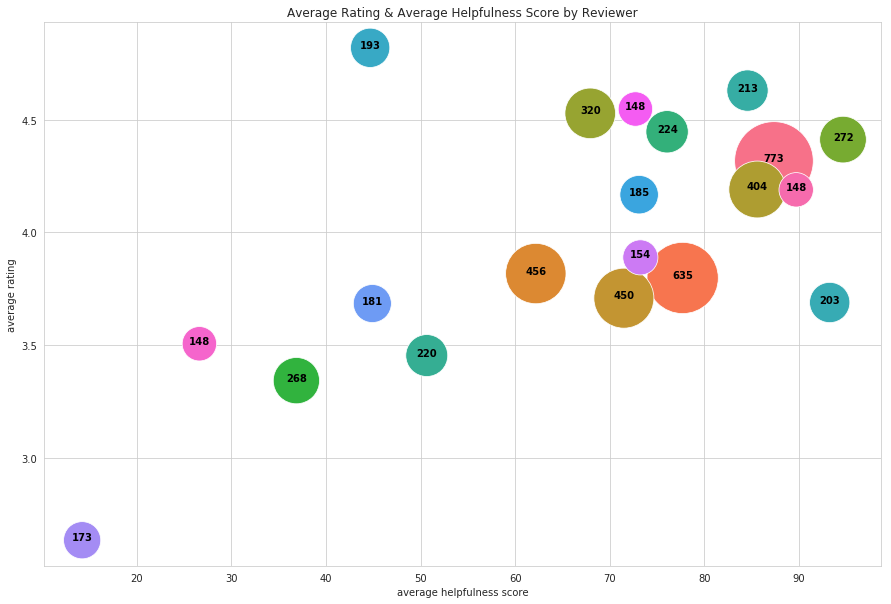

In [67]:
sns.set_style("whitegrid")

fig, ax = plt.subplots(figsize=(15, 10))

p1 = sns.scatterplot(x = x, y = y, data=data, s = 8*z, hue = hue)

for line in range(0,data.shape[0]):
     p1.text(data['average helpfulness score'][line]+0.01, data['average rating'][line], 
     data['total number of reviews'][line], horizontalalignment='center', 
     size='medium', color='black', weight='semibold')

ax.legend_.remove()

plt.title("Average Rating & Average Helpfulness Score by Reviewer")

plt.show()

### Pretty interesting!  We see a nice spread of average helpfulness score and average rating, and based on this output, it seems like the better the helpfulness score, the better the rating gets.  What we can't determine is if that is because the reviewers who are most helpful are reviewing highly rated products, but you could make the case that you want to make sure that reviewers are putting good content when talking about your products.

 # [10] Look into Most Reviewed Products
 ### Create a dataframe of the top ten products with the most reviews
 * First we need to aggregate the dataframe to show total number of reviews
 * Then we can use this to calculate share of reviews for an individual product across all products

In [68]:
tot = helpfulness_df.count()

top_products = helpfulness_df.groupBy("asin").count() \
  .withColumnRenamed('count', 'num_reviews') \
  .withColumn('percent_of_total', (col('num_reviews') / tot) * 100 ) \
  .orderBy("num_reviews", ascending = False) \

Let's look at a sample

In [69]:
top_ten_products = top_products.limit(10).toPandas()

In [70]:
top_ten_products

,asin,num_reviews,percent_of_total
0,B00BGA9WK2,802,0.346018
1,B0015AARJI,652,0.281301
2,B007CM0K86,517,0.223056
3,B002VBWIP6,465,0.200621
4,B0009VXBAQ,447,0.192855
5,B0050SYX8W,441,0.190267
6,B000B9RI14,425,0.183364
7,B00178630A,379,0.163517
8,B007XVTR3K,365,0.157477
9,B00005NZ1G,356,0.153594


### We used https://amazon-asin.com/ to grab the product name and price of the top 10 products, see below

In [71]:
## 1. B00BGA9WK2 - PlayStation 4 500GB Console - $319.99
## 2. B0015AARJI - PlayStation 3 Dualshock 3 Wireless Controller (Black) - $99.99
## 3. B007CM0K86 - The Last of Us - PlayStation 3 - $19.81
## 4. B002VBWIP6 - Xbox Live Gold: 12 Month Membership [Digital Code] - $59.99
## 5. B0009VXBAQ - Wii - $659.99
## 6. B0050SYX8W - Halo 4 - Xbox 360 (Standard Game) - $23.13
## 7. B000B9RI14 - Xbox 360 LIVE 1600 Points - $0.00
## 8. B00178630A - Diablo III - $19.96
## 9. B007XVTR3K - Call of Duty: Black Ops II - Xbox 360 - $21.49
## 10. B00005NZ1G - Halo: Combat Evolved (Not for Resale) - $39.98

### We put the product names into a list to add it to our dataframe, and then just show the result

In [72]:
prodnames = ['PlayStation 4 500GB Console', 'PlayStation 3 Dualshock 3 Wireless Controller (Black)', 'The Last of Us - PlayStation 3',
            'Xbox Live Gold: 12 Month Membership [Digital Code]', 'Wii', 'Halo 4 - Xbox 360 (Standard Game)', 'Xbox 360 LIVE 1600 Points',
            'Diablo III', 'Call of Duty: Black Ops II - Xbox 360', 'Halo: Combat Evolved (Not for Resale)']

In [73]:
top_ten_products['product'] = prodnames

In [74]:
top_ten_products

,asin,num_reviews,percent_of_total,product
0,B00BGA9WK2,802,0.346018,PlayStation 4 500GB Console
1,B0015AARJI,652,0.281301,PlayStation 3 Dualshock 3 Wireless Controller ...
2,B007CM0K86,517,0.223056,The Last of Us - PlayStation 3
3,B002VBWIP6,465,0.200621,Xbox Live Gold: 12 Month Membership [Digital C...
4,B0009VXBAQ,447,0.192855,Wii
5,B0050SYX8W,441,0.190267,Halo 4 - Xbox 360 (Standard Game)
6,B000B9RI14,425,0.183364,Xbox 360 LIVE 1600 Points
7,B00178630A,379,0.163517,Diablo III
8,B007XVTR3K,365,0.157477,Call of Duty: Black Ops II - Xbox 360
9,B00005NZ1G,356,0.153594,Halo: Combat Evolved (Not for Resale)


## VISUALIZE
### Create a visualization using Seaborn to display the Top 10 Products by Reviews

* Create a few new variables so we don't overwrite the ones we created above
* `prod_x` is simply our number of reviews
* `prod_y` is the product name

In [75]:
prod_x = top_ten_products['num_reviews']
prod_y = top_ten_products['product']

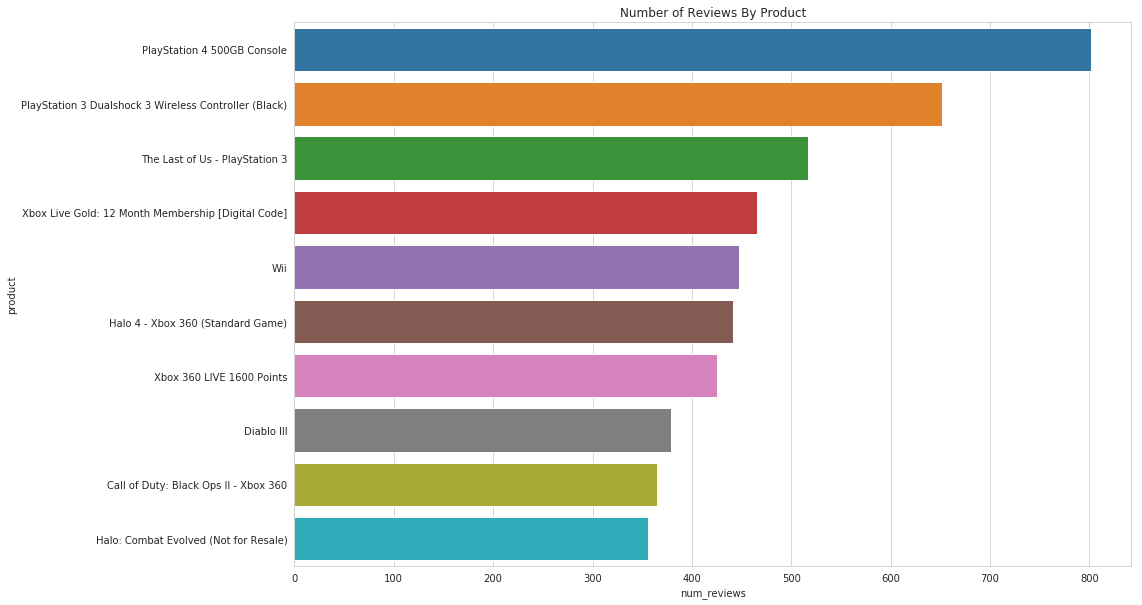

In [76]:
sns.set_style("whitegrid")

fig, ax = plt.subplots(figsize=(15, 10))

sns.barplot(y = prod_y, x = prod_x, ax = ax)

plt.title("Number of Reviews By Product")

plt.show()

### For the timeframe of the data (~2000 to 2014), it looks like Playstation 4 was just entering into the market, and so this makes sense that it would be the product with the most reviews.  What was interesting to our group is the broad mixture of products that were being reviewed - two consoles, two online membership download codes, one peripheral (the PS3 controller), two Xbox 360 games, one Playstation 3 game, and one PC game.


# [11] TIME SERIES ANALYSIS
## PREPARATAION
* First start with the helpfulness df
* We need to convert "Review_Time" into individual columns for Month Day and Year
* Rename the columns for easier reading

In [77]:
with_time_df = helpfulness_df.select("*", split(helpfulness_df.reviewTime, " ").alias("Review_Time"))

with_time_df = with_time_df.withColumn("Month", with_time_df.Review_Time[0]) \
            .withColumn("Day", with_time_df.Review_Time[1]) \
            .withColumn("Year", with_time_df.Review_Time[2] )

In [78]:
with_time_df = with_time_df.withColumn("Review_Length", length("reviewText"))

Let's review the data to make sure the transofmraiton worked as intended
* take a limited sample of the data
* print the schema to see all of the columns and datatypes

In [79]:
with_time_df.limit(5).toPandas()

,asin,helpful,overall,reviewText,reviewTime,reviewerID,reviewerName,summary,unixReviewTime,helpful_votes,total_votes,perc_helpful,Review_Time,Month,Day,Year,Review_Length
0,0700099867,"[8, 12]",1.0,Installing the game was a struggle (because of...,"07 9, 2012",A2HD75EMZR8QLN,123,Pay to unlock content? I don't think so.,1341792000,8,12,66.666667,"[07, 9,, 2012]",07,"9,",2012,779
1,0700099867,"[0, 0]",4.0,If you like rally cars get this game you will ...,"06 30, 2013",A3UR8NLLY1ZHCX,"Alejandro Henao ""Electronic Junky""",Good rally game,1372550400,0,0,NaN,"[06, 30,, 2013]",06,"30,",2013,304
2,0700099867,"[0, 0]",1.0,1st shipment received a book instead of the ga...,"06 28, 2014",A1INA0F5CWW3J4,"Amazon Shopper ""Mr.Repsol""",Wrong key,1403913600,0,0,NaN,"[06, 28,, 2014]",06,"28,",2014,282
3,0700099867,"[7, 10]",3.0,"I got this version instead of the PS3 version,...","09 14, 2011",A1DLMTOTHQ4AST,ampgreen,"awesome game, if it did not crash frequently !!",1315958400,7,10,70.000000,"[09, 14,, 2011]",09,"14,",2011,3489
4,0700099867,"[2, 2]",4.0,I had Dirt 2 on Xbox 360 and it was an okay ga...,"06 14, 2011",A361M14PU2GUEG,"Angry Ryan ""Ryan A. Forrest""",DIRT 3,1308009600,2,2,100.000000,"[06, 14,, 2011]",06,"14,",2011,294


In [80]:
with_time_df.printSchema()

root
 |-- asin: string (nullable = true)
 |-- helpful: array (nullable = true)
 |    |-- element: long (containsNull = true)
 |-- overall: double (nullable = true)
 |-- reviewText: string (nullable = true)
 |-- reviewTime: string (nullable = true)
 |-- reviewerID: string (nullable = true)
 |-- reviewerName: string (nullable = true)
 |-- summary: string (nullable = true)
 |-- unixReviewTime: long (nullable = true)
 |-- helpful_votes: long (nullable = true)
 |-- total_votes: long (nullable = true)
 |-- perc_helpful: double (nullable = true)
 |-- Review_Time: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- Month: string (nullable = true)
 |-- Day: string (nullable = true)
 |-- Year: string (nullable = true)
 |-- Review_Length: integer (nullable = true)



## TRANSFORM
* The data fields need to be converted to numbers
* We are going to use `SQLTransformer` to create a function we can use to `transform` the data set
* By building it this way, we will be able to reuse the transformer in the future, or even build it into a `pipeline`

In [81]:
st = SQLTransformer(statement="""
select *, case when Day == '1,' then 1
when Day == '2,' then 2
when Day == '3,' then 3
when Day == '4,' then 4
when Day == '5,' then 5
when Day == '6,' then 6
when Day == '7,' then 7
when Day == '8,' then 8
when Day == '9,' then 9
when Day == '10,' then 10
when Day == '11,' then 11
when Day == '12,' then 12
when Day == '13,' then 13
when Day == '14,' then 14
when Day == '15,' then 15
when Day == '16,' then 16
when Day == '17,' then 17
when Day == '18,' then 18
when Day == '19,' then 19
when Day == '20,' then 20
when Day == '21,' then 21
when Day == '22,' then 22
when Day == '23,' then 23
when Day == '24,' then 24
when Day == '25,' then 25
when Day == '26,' then 26
when Day == '27,' then 27
when Day == '28,' then 28
when Day == '29,' then 29
when Day == '30,' then 30
when Day == '31,' then 31
end as Day_Int
from __THIS__
""")

In [82]:
with_time_df = st.transform(with_time_df)

Now we need to convert all of the other columns into the correct datatypes  by using `CAST`

In [83]:
with_time_df = with_time_df.selectExpr ("cast(asin as string)", "cast(overall as double)", "cast(reviewText as string)", \
"cast(reviewTime as string)", "cast(reviewerID as string)", "cast(reviewerName as string)", \
"cast(summary as string)", "cast(unixReviewTime as long)", "cast(helpful_votes as long)", \
"cast(total_votes as long)", "cast(perc_helpful as double)", \
"cast(Month as double)", "cast(Year as double)", "cast(Day_Int as double)", "cast(Review_Length as double)")

### Check out Reviewers by Year

Let's create some aggregation columns
* unique number of reviewers
* unqiue number of products
* average product rating
* average helpfulness rating
* total number of views

Then we'll sort it by Year

In [84]:
reviewers_year = with_time_df.groupBy("Year").agg(countDistinct("reviewerID").alias("Number of Reviewers"), \
countDistinct("ASIN").alias("Number of Products"), round(mean("overall"),2).alias("Average Product Rating"), \
round(mean("Review_Length"),2).alias("Average Review Length (words)"),
round(mean("perc_helpful"),2).alias("Average Helpfulness Percentage"),count("helpful_votes").alias("Total Number of Reviews")) \
.orderBy('Year', ascending = True)

Let's review the data and the schema (using `dtypes`, a function of df)

In [85]:
reviewers_year_df = reviewers_year.toPandas()

In [86]:
reviewers_year_df.dtypes

Year                              float64
Number of Reviewers                 int64
Number of Products                  int64
Average Product Rating            float64
Average Review Length (words)     float64
Average Helpfulness Percentage    float64
Total Number of Reviews             int64
dtype: object

In [87]:
reviewers_year_df

,Year,Number of Reviewers,Number of Products,Average Product Rating,Average Review Length (words),Average Helpfulness Percentage,Total Number of Reviews
0,1999.0,32,48,4.29,673.68,83.20,63
1,2000.0,459,541,4.06,1145.14,71.11,1736
2,2001.0,1210,1032,4.12,1121.10,69.10,4935
3,2002.0,1661,1356,4.11,1181.44,65.14,7310
4,2003.0,1722,1623,4.08,1324.26,66.05,7051
5,2004.0,1960,1746,4.01,1421.45,65.23,7274
6,2005.0,2072,2000,4.02,1588.33,67.05,7824
7,2006.0,2227,2006,3.92,1705.12,68.41,6909
8,2007.0,3076,2488,4.00,1326.08,66.57,9615
9,2008.0,4245,2978,3.94,1375.53,66.57,13127


### VISUALIZE Reviews by Year
* We will use Seaborn to make time series graphs

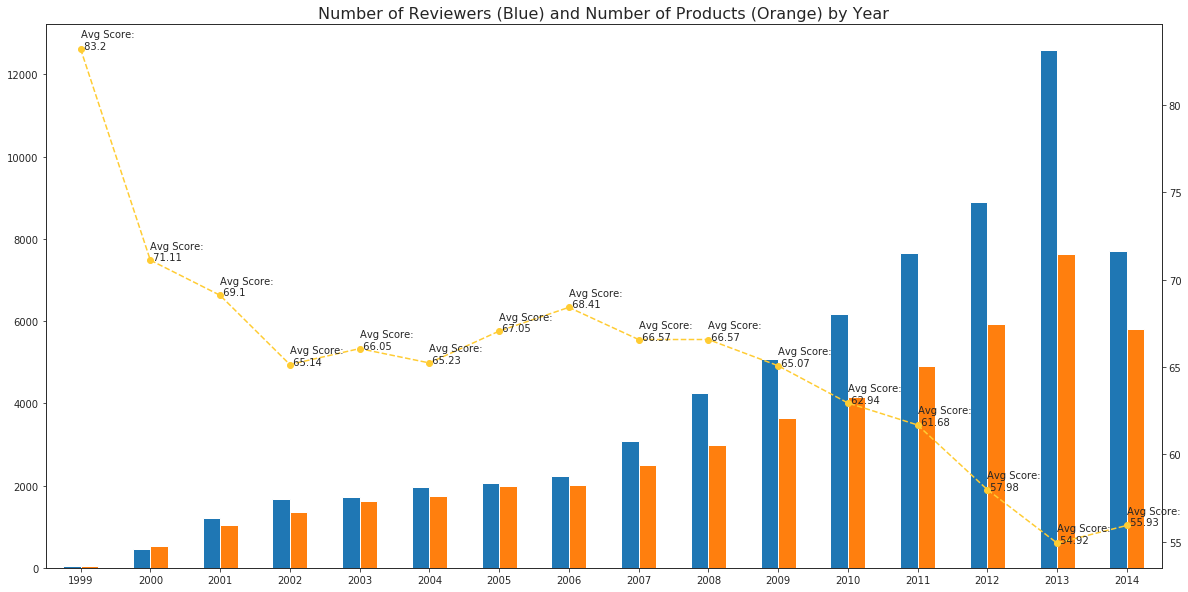

In [88]:
## Seaborn is the best!
sns.set_style("white")
sns.set_style("ticks")

fig, ax = plt.subplots(figsize=(20, 10))

## Create our bar plots first
reviewers_year_df[["Number of Reviewers", "Number of Products"]].plot(kind = "bar", ax = ax)

## Set our x labels
ax.set_xticklabels(("1999", "2000", "2001", "2002", "2003", "2004", "2005", "2006", "2007", "2008",
                  "2009", "2010", "2011", "2012", "2013", "2014"))

## Create a line plot to overlay on top of our bar graph, with the GOLD for pizzazz
p2 = reviewers_year_df["Average Helpfulness Percentage"].plot(secondary_y = True, color = '#ffcc33', ax = ax, ls = '--', marker = "o")

## Add data labels for each score - we can see the trend over time is very poor
for i,j in reviewers_year_df["Average Helpfulness Percentage"].items():
    p2.annotate("Avg Score:\n {}".format(str(j)), xy=(i, j))

## Add a title to help our readers understand what is being plotted
plt.title("Number of Reviewers (Blue) and Number of Products (Orange) by Year", fontsize = 16)

## Remove the legend since we call out what we're displaying
ax.get_legend().remove()

## Show the final product
plt.show()

### Check out Monthly Trends
* We will group the data by month and aggregate

In [89]:
trends_by_year_month = with_time_df.groupBy("Month", "Year").agg(countDistinct("reviewerID").alias("Number of Reviewers"), \
countDistinct("ASIN").alias("Number of Products"), round(mean("overall"), 2).alias("Average Product Rating"), \
round(mean("Review_Length"),2).alias("Average Review Length (words)"),
round(mean("perc_helpful"),2).alias("Average Helpfulness Percentage"),count("helpful_votes").alias("Total Number of Reviews")) \
.orderBy("Month", "Year", ascending = True)

* Create a new variable combining Month & Year together

In [90]:
trends_by_year_month_df = trends_by_year_month.toPandas()
trends_by_year_month_df["Month, Year"] = trends_by_year_month_df["Month"].astype(str) + trends_by_year_month_df["Year"].astype(str)

* Let's view a sample

In [91]:
trends_by_year_month_df.head(5)

,Month,Year,Number of Reviewers,Number of Products,Average Product Rating,Average Review Length (words),Average Helpfulness Percentage,Total Number of Reviews,"Month, Year"
0,1.0,2000.0,31,40,3.79,1142.60,71.30,53,1.02000.0
1,1.0,2001.0,164,201,4.13,1179.94,71.98,324,1.02001.0
2,1.0,2002.0,339,325,4.16,1053.82,65.66,599,1.02002.0
3,1.0,2003.0,313,366,4.08,1271.34,66.46,615,1.02003.0
4,1.0,2004.0,369,487,4.00,1270.10,65.26,826,1.02004.0


### VISUALIZE Trends by Month&Year

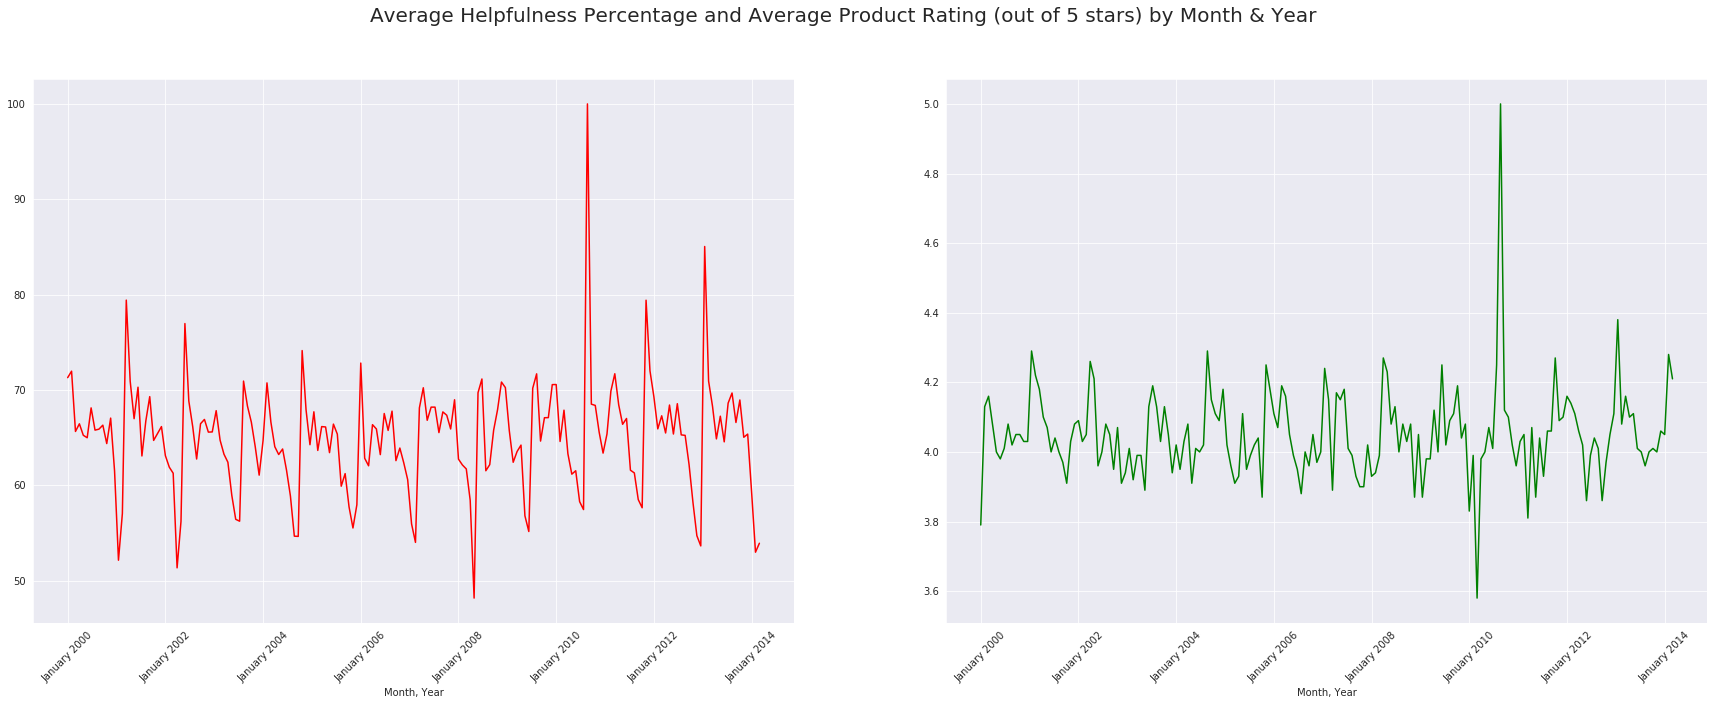

In [92]:
## Use a different Seaborn background to add a little variety
sns.set_style("darkgrid")

## We're creating two lines graphs side by side, making them a bit wider
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(30, 10))

## First we plot the Average Helpfulness Percentage by Month and Year
trends_by_year_month_df.plot(x = "Month, Year", y = "Average Helpfulness Percentage", ax = ax1, color = 'r', ls = '-')

## We're going to guesstimate a little bit here on the labels, with such a huge timespan for the data we try to split it evenly
ax1.set_xticklabels(("0","January 2000","January 2002", "January 2004", "January 2006", "January 2008", "January 2010", "January 2012", "January 2014"), rotation = 45.0)

## Remove the legend since it's not needed
ax1.legend_.remove()

## Create our second graph, now we're plotting the Average Product Rating by Month and Year
trends_by_year_month_df.plot(x = "Month, Year", y = "Average Product Rating", ax = ax2, color = 'g', ls = '-')

## Same as above, guesstimating just a tad on the labels.  But the idea is to show the flunctuations over time
ax2.set_xticklabels(("0","January 2000","January 2002", "January 2004", "January 2006", "January 2008", "January 2010", "January 2012", "January 2014"), rotation = 45.0)

## Remove those pesky legends!
ax2.legend_.remove()

## Add a descriptive title for our audience
plt.suptitle("Average Helpfulness Percentage and Average Product Rating (out of 5 stars) by Month & Year", fontsize = 20)

## Show the two new graphs side by side!
plt.show()

### Check out Reviewers by Month
* Group by Month and aggreate our metrics

In [93]:
reviewers_by_month = with_time_df.groupBy("Month").agg(countDistinct("reviewerID").alias("Number of Reviewers"), \
countDistinct("ASIN").alias("Number of Products"), round(mean("overall"), 2).alias("Average Product Rating"), \
round(mean("Review_Length"),2).alias("Average Review Length (words)"),
round(mean("perc_helpful"),2).alias("Average Helpfulness Percentage"),count("helpful_votes").alias("Total Number of Reviews")) \
.orderBy('Month', ascending = True)

### VISUALIZE Reviewers by Month

In [94]:
reviewers_by_month_df = reviewers_by_month.toPandas()

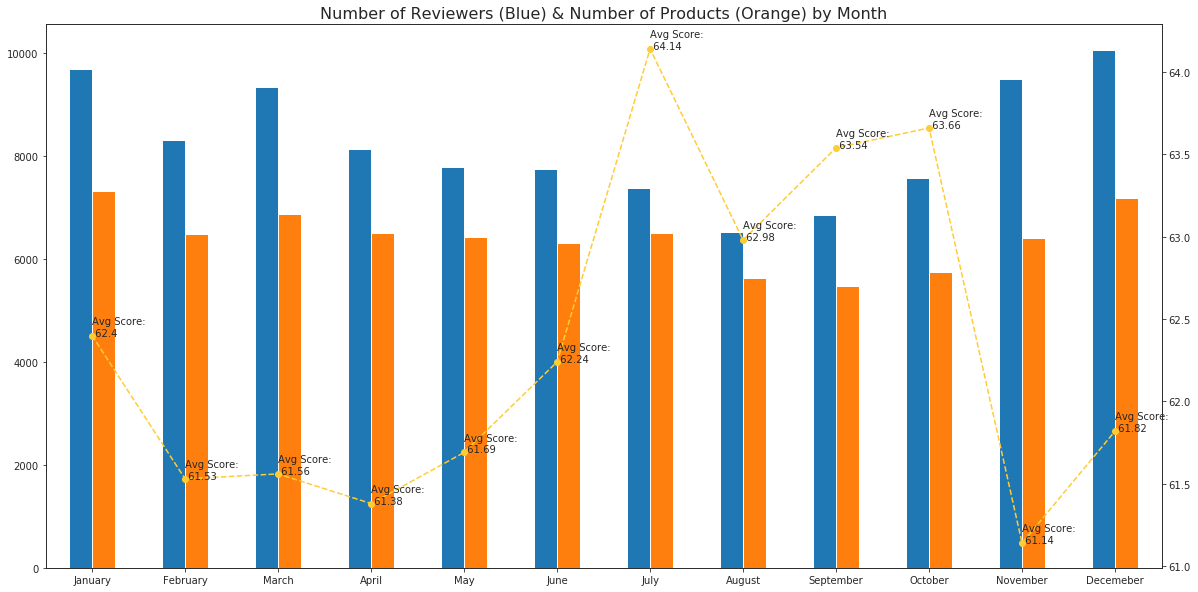

In [95]:
## Seaborn again!
sns.set_style("white")
sns.set_style("ticks")

fig, ax = plt.subplots(figsize=(20, 10))

## Create our bar plots first
reviewers_by_month_df[["Number of Reviewers", "Number of Products"]].plot(kind = "bar", ax = ax)

## Set our x labels
ax.set_xticklabels(("January", "February", "March", "April", "May", "June", "July", "August", "September",
                  "October", "November", "Decemeber"), rotation = 45.0)

## Create a line plot to overlay on top of our bar graph, with the GOLD for Goldy
p2 = reviewers_by_month_df["Average Helpfulness Percentage"].plot(secondary_y = True, color = '#ffcc33', ax = ax, ls = '--', marker = "o")

## Add data labels for our line graph
for i,j in reviewers_by_month_df["Average Helpfulness Percentage"].items():
    p2.annotate("Avg Score:\n {}".format(str(j)), xy=(i, j))

## Add a descriptive title
plt.title("Number of Reviewers (Blue) & Number of Products (Orange) by Month", fontsize = 16)

## Get rid of the legend since it's not needed
ax.get_legend().remove()

## Show the beautiful vis!
plt.show()

# [12] SAMPLING
* Let's create a sample to complete the analysis, so other's can try on a smaller dataset

### Creating a sample data file from the original file so that anyone can do a sample analysis

In [96]:
! cat reviews_Video_Games_5.json | head -10000 > reviews_Video_Games_sample.json

cat: write error: Broken pipe


### Verify the data file was created successfully

In [97]:
! ls -l reviews_Video_Games*

-rw-rw-r-- 1 vagrant vagrant 319473515 Apr 26  2016 reviews_Video_Games_5.json
-rw-rw-r-- 1 vagrant vagrant  13010067 Aug 25 15:01 reviews_Video_Games_sample.json


In [98]:
! head -1 reviews_Video_Games_sample.json

{"reviewerID": "A2HD75EMZR8QLN", "asin": "0700099867", "reviewerName": "123", "helpful": [8, 12], "reviewText": "Installing the game was a struggle (because of games for windows live bugs).Some championship races and cars can only be \"unlocked\" by buying them as an addon to the game. I paid nearly 30 dollars when the game was new. I don't like the idea that I have to keep paying to keep playing.I noticed no improvement in the physics or graphics compared to Dirt 2.I tossed it in the garbage and vowed never to buy another codemasters game. I'm really tired of arcade style rally/racing games anyway.I'll continue to get my fix from Richard Burns Rally, and you should to. :)http://www.amazon.com/Richard-Burns-Rally-PC/dp/B000C97156/ref=sr_1_1?ie=UTF8&qid;=1341886844&sr;=8-1&keywords;=richard+burns+rallyThank you for reading my review! If you enjoyed it, be sure to rate it as helpful.", "overall": 1.0, "summary": "Pay to unlock content? I don't think so.", "unixReviewTime": 1341792000, "r

In [99]:
! wc -l reviews_Video_Games_sample.json

10000 reviews_Video_Games_sample.json


# DATA SOURCES & BIBLIOGRAPHY

[1] R. He, J. McAuley. (2016). _Ups and Downs: Modeling the Visual Evolution of Fashion Trends with One-Class Collaborative Filtering_ [PDF File].  Retreived August 2019, from WWW: http://jmcauley.ucsd.edu/data/amazon/
<br>
[2] McDonald, Carol. (2019).  _Streaming ML Pipeline for Sentiment Analysis Using Apache APIs: Kafka, Spark, and Drill (Part 1)_.  Retreived August 2019, from WWW: https://dzone.com/articles/streaming-machine-learning-pipeline-for-sentiment